In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
from tqdm import tqdm
from scipy.linalg import eigvals
from scipy.stats import laplace
from scipy.stats import multivariate_normal
from scipy.special import expit 
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

# Bayesian Logistic Regression with Laplace prior

Dans ce notebook, nous appliquons la Stochastic Gradient Langevin Dynamics afin d'effectuer une Bayesian Logistic Regression avec une prior de Laplace de scale $b=1$. Nous comparons également la Stochastic Gradient Langevin Dynamics à d'autres méthodes d'échantillonnage (adaptative symetric random walk par exemple) afin de tester son efficacité et notamment sa rapidité.

On rappelle le modèle:

- $p(\beta) \sim \mathcal{L}(0, 1)$ i.e $p(\beta) \propto \exp(-\|\beta\|_1)$,

- $ \forall i \in \{1, ..., N\}, y_i \sim \mathcal{B}\left(\sigma(\beta^{\top}x_i)\right)$ i.i.d, où $\sigma$ est la fonction sigmoïde. En utilisant la propriété $\forall z \in \mathbb{R}, \sigma(-z) = 1 - \sigma(z)$ on peut écrire: $\forall i \in \{1, ..., N\}, p(y_i | \beta, x_i) = \sigma(y_i \cdot \beta^{\top}x_i)$.

On a alors $\log p(\beta | X, y) \propto_+  \sum_{i=1}^N \log \sigma(y_i \cdot \beta^{\top}x_i) - \| \beta \|_1$.

On peut alors écrire un sous-gradient de la log-posterior en utilisant le fait que: $\forall z \in \mathbb{R}, \sigma'(z) = (1 - \sigma(z)) \cdot \sigma(z)$ et qu'un sous-gradient de la log-prior est $\partial_{\beta} \log p(\beta) = - \mathrm{sign}(\beta)$: 
$ \partial_{\beta} \log p(\beta | X, y) = \sum_{i=1}^N y_i \cdot x_i \left( 1 - \sigma(y_i \cdot \beta^{\top}x_i) \right) - \mathrm{sign}(\beta)$.

## 1. Stochastic Gradient Langevin Dynamics

Cette méthode a pour but d'allier **optimisation** (SGD) et **échantillonnage** (Langevin) en **une seule et unique méthode** afin d'étendre les méthodes bayésiennes aux cas de grands datasets.   

Sa grande force (mais qui fait aussi sa faiblesse, nous y reviendrons...) est qu'elle permet à la façon d'une méthode de Robbins-Monro d'échantillonner sans avoir à effectuer un calcul à partir du dataset entier. La **SGLD** utilise les données  par **batch**, contrairement à la **majorité** des méthodes **MCMC** qui utilisent **tout le training set**. Par exemple, une symetric random walk nécéssite à chaque itération de calculer la probabilité d'acceptation du candidat, qui est un rapport de densité ($\alpha = \mathrm{min}(1, \pi(\theta_t) \, / \, \pi(\tilde{\theta}_t))$ où $\pi$ est notre loi cible, en l'occurence la posterior sur les paramètres dans le cadre bayésien). Ceci peut donc s'avérer extrêmement couteux lorsque le nombre de points dans le dataset est important. 

Dès lors que la phase d'**optimisation** est terminée, i.e que l'on se stabilise dans un zone de forte probabilité de la posterior (attention, pas necessairement dans un unique mode, l'idée est d'explorer des zones de forte probabilité autres que le mode donné par le MAP uniquement), l'algorithme **échantillonne** selon cette loi. Comme avec toute méthode MCMC, le théorème ergodique nous permet d'approximer des calculs d'éspérance et donc de **predictive distribution**.

### 1.1 A brief summary of the method

#### An iteration

En exploitant les calculs précédents, l'itération $t$ de la **SGLD** s'écrit:

- Selectionner un batch $B_t = \{x_{1}, ..., x_{n}\}$ et calculer la step-size $\epsilon_t = a \cdot (b+t)^{-\gamma}$

- Échantilloner $\eta_t \sim \mathcal{N}(0,\epsilon_t \cdot I)$

- Mettre à jour $\beta_{t+1} \leftarrow \beta_t - \frac{1}{2} \epsilon_t \cdot \left[ \frac{N}{n} \sum_{i=1}^n y_i \cdot x_i \left( 1 - \sigma(y_i \cdot \beta^{\top}x_i) \right) -  \mathrm{sign}(\beta)\right] - \eta_t$

#### Optimisation (SGD) and Sampling phase (Langevin)

Il est peut être assez difficile d'estimer précisemment le **début** de la phase d'**échantillonnage** sans avoir à calculer la posterior à chaque itération, ce qui ferait perdre à la méthode toute son utilité puisqu'on devrait calculer une quantité nécessitant le traitement du dataset entier. De plus, cette estimation est très importante dans le mesure où l'inclusion d'échantillons de la phase d'optimisation dans les **calculs d'éspérances** biaserait fortement ces derniers.

L'article fournit une méthode **empirique** d'estimation du début de la phase de sampling. **ToDo:** expliquer cette méthode.

#### Predictive distribution 

En utilisant les échantillons fournis par l'algorithme et en fixant un seuil $t_0$ (burn-in) à partir duquel on suppose être dans la phase de sampling (i.e en supposant que $(\beta_t)_{t\in\{t_0, ..., T\}}$ sont distribués selon la posterior, on peut approximer la **predictive distribution** du label $y^*$ d'un **nouvel échantillon** $x^*$ par **Monte Carlo**: $p(y^* | x^*, X, y) = \mathbb{E}_{p(\beta|X,y)}\left[\, p(y^*|\beta,x^*)\, \right] \approx \frac{1}{T-t_0} \sum_{i=t_0}^T p(y^*|\beta_t, x^*)$.  
On obtient alors, pour $x^*$ un nouvel échantillon: $p(y^*=1|x^*, X, y) \approx \frac{1}{T-t_0} \sum_{t=t_0}^T \sigma(\beta_t^{\top} x^*)$. 

De plus, il est interessant de préciser que l'article suppose une autre façon de calculer des éspérances selon la posterior en utilisant les step-sizes calulées à chaque itération et approximer: $\mathbb{E}_{p(\beta|X,y)}\left[p(y^*|\beta,x^*)\, \right] \approx \frac{1}{T-t_0} \sum_{t=t_0}^T  \epsilon_t \, p(y^*|\beta_t, x^*) \, / \, \sum_{t=t_0}^T \epsilon_t$.  
L'idée est de contrer le fait que les step-sizes $\epsilon_t {\rightarrow 0}$ quand $t \rightarrow \infty$ donc le **taux de mélange** de la chaîne de markov diminue et les échantillons deviennent de **plus en plus corrélés** à mesure que l'on échantillonne. On **pondère** ainsi la contribution de chaque échantillon à l'approximation de l'éspérance en fonction de la step-size correspondante. Comme $\sum_{t} \epsilon_t = \infty$, cet estimateur de l'éspérance est toujours consistant.

#### Predictions and benefits of Bayesian methods

Si l'on veut faire de la "hard-classification", on peut alors prédire $\hat{y}^* = \mathbb{1}_{\{p(y^*=1|x^*, X, y) \geq p_0\}}$ où $p_0$ est une probabilité de seuil qui peut être optimisée selon les types de métriques que l'on veut optimiser (precision, recall, accuracy...). Toutefois, l'intérêt majeur de cette méthode est qu'elle permet d'estimer **l'incertitude** et donc la **robustesse** de notre **prédiction**, ce qui est fondamental dans de nombreux domaines (médical, contrôle...). 

Il est vrai qu'une **logistic regression classique** fournit par le biais de la likelihood de Bernoulli une estimation de la probabilité de la classe d'un nouvel échantillon sachant le paramètre: $p(y^* | x^*, \hat{w}) = \sigma(x^{* \top} \hat{w})$ où $\hat{w}$ peut être l'estimateur MAP ou ML du paramètre.  
En revanche, il a été montré dans cet article: On calibration of modern neural networks [Guo et al., 2017] Guo, C., Pleiss, G., Sun, Y., and Weinberger, K. Q. (2017), que ce type de classifieurs est **sur-confiant**. Cet article traite de réseaux de neurones mais la logistic-regression (binary ou multiclass) est un cas particulier simple de réseau de neurone utilisant des couches finales de type sigmoïde ou softmax. Par exemple, s'ils prédisent $p(y^* = 1 | x^*, \hat{w}) = 0.9$, cette prédicion ne s'avère pas vraie dans 90% des cas, comme ce qui serait suggéré par cette probabilité. En revanche, les **méthodes bayésiennes** fournissent par le biais de la predictive distribution une **estimation** bien plus **effective** de l'**incertitude** sur la prédiction.

### 1.2 Implementation

In [23]:
def get_step_size(a, b, gamma, t):
    """
    Get the step size for parameters (a, b, gamma) at iteration t.
    Arguments:
      a: float, plays a role of learning rate
      b: float, controls the learning rate decay for the first iterations
      gamma: float in (.5, 1], controls step size decay
      t: int, iteration number
    Return:
      float, step_size
    """
    return a * (b + t) ** (- gamma)

def post_laplace(beta, X, y):
    """
    Evaluate the (unormalized) posterior over the whole training set in beta.
    For numerical stability, prefer np.exp(log_post_laplace(beta, X, y)) to compute posterior pdf.
    Arguments:
      beta: np.array, parameter of logistic regression
      X: np.array,  training examples 
      y: np.array, training labels 
    Return:
      float, (unormalized) posterior evaluated in beta
    """
    return np.product(expit(y * (X @ beta))) * np.exp(- np.linalg.norm(beta, ord=1))

def log_post_laplace(beta, X, y):
    """
    Evaluate the (unormalized) log-posterior pdf over the whole training set in beta.
    Arguments:
      beta: np.array, parameter of logistic regression
      X: np.array,  training examples 
      y: np.array, training labels 
    Return:
      float, (unormalized) log-posterior evaluated in beta
    """
    return (np.log(expit(y * (X @ beta)))).sum(axis=0) - np.linalg.norm(beta, ord=1)

def gradient_laplace(beta, batch_X, batch_y, n_samples, bool_cov_score=False):
    """
    Get a sub-gradient of the log-posterior pdf w.r.t beta for a given batch.
    Arguments:
      beta: np.array, parameter of logistic regression
      batch_X: np.array, batch of training examples 
      y: np.array, labels of training examples in the batch
      n_samples, int, number of samples in the training set
      bool_cov_score: boolean, if True compute the covariance of the score (to estimate the beginning of the sampling phase)
    Return:
      batch_grad: np.array, sub-gradient of the log-posterior w.r.t beta for the given batch
      cov_score: np.array, empirical covariance of the score (score = partial gradient for each sample in the batch + 1/n_samples sub-gradient of the prior)
    """
    # get batch gradient 
    res = (expit(- batch_y * (batch_X @ beta)) * batch_y)[:, None] * batch_X
    batch_grad = (n_samples / len(batch_X)) * res.sum(axis=0) - np.sign(beta)
    if bool_cov_score==False:
        return batch_grad
    
    # get empirical covariance of the score if required
    else:
        # get score 
        res2 = res - (1/n_samples) * np.sign(beta)
        # get empirical covariance
        cov_score = (1 / len(batch_X)) * (res2 - res2.sum(0)).T @ (res2 - res2.sum(0))
        return batch_grad, cov_score 

def SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackW=False, bool_trackL=False, bool_trackA=False):
    """
    SGLD for Bayesian Logistic Regression with Laplace Prior.
    Arguments:
      X: np.array,  training examples 
      y: np.array, training labels
      n_iter: int, number of iterations
      a: float, plays a role of learning rate
      b: float, controls the learning rate decay for the first iterations
      gamma: float in (.5, 1], controls step size decay
      beta_0: np.array, initial beta 
      batch_size: int, size of the batch 
      bool_trackL: boolean, if True compute and return the log-posterior at each step (costly: require a pass over the whole training set)
      bool_weights: boolean, if True return the weights at each iteration to compute posterior expectation (as proposed in the article)
      bool_trackA: boolean, if True compute and return the alpha to evaluate begining of the sampling phase (see article for expression)
    Return:
      tackL: np.array, log-posterior evaluate at each step
      betas: np.array, paremeters at each step
    """
    start = time.time()
    N, dim = X.shape
    beta = beta_0
    betas = np.concatenate((beta[None, :], np.zeros((n_iter, dim))), axis=0)
    
    # compute and store log-posterior throughout the iterations if required
    if bool_trackL: 
        trackL = np.concatenate(([log_post_laplace(beta, X, y)], np.zeros(n_iter)))
        
    # store weights throughout the iterations if required
    if bool_trackW:
        trackW = np.zeros(n_iter)
    
    # store weights throughout the iterations if required
    if bool_trackA:
        trackA = np.zeros(n_iter)
    
    for ii in tqdm(range(n_iter)):
                
        # select a batch of size batch_size
        idxs = np.random.choice(N, size=batch_size)
        batch_X = X[idxs]
        batch_y = y[idxs]
        
        ### STEP 1: ###
        # compute step size 
        step_size = get_step_size(a, b, gamma, t=ii)
        
        ### STEP 2: ###
        # sample noise
        eta = multivariate_normal.rvs(mean=np.zeros(dim), cov=step_size*np.eye(dim))
        
        ### STEP 3: ###
        # update and store parameter
        if bool_trackA:
            grad, cov_score = gradient_laplace(beta, batch_X, batch_y, n_samples=N, bool_cov_score=True)
        else:
            grad = gradient_laplace(beta, batch_X, batch_y, n_samples=N)
        beta = beta + (step_size / 2) * grad + eta 
        betas[ii+1] = beta
        
        # compute and store log-posterior if required
        if bool_trackL:
            trackL[ii+1] = log_post_laplace(beta, X, y)
            
        # store weights if required
        if bool_trackW:
            trackW[ii] = step_size
            
        # compute and store alpha if required
        if bool_trackA:
            trackA[ii] = ((step_size * N**2) / (4 * len(batch_X))) * np.amax(np.real(eigvals(cov_score)))
            
    end = time.time()
    time.sleep(.1)
    print(f"Done in {round(end-start, 2)} s.")
    
    if bool_trackA & bool_trackW & bool_trackL:
        return betas,trackA, trackW, trackL
    if bool_trackA & bool_trackW: 
        return betas, trackA, trackW
    if bool_trackA & bool_trackL: 
        return betas, trackA, trackL
    if bool_trackW & bool_trackW: 
        return betas, trackW, trackL
    if bool_trackA:
        return betas, trackA 
    if bool_trackW:
        return betas, trackW
    if bool_trackL:
        return betas, trackL
    else:
        return betas
    
    
def predictive_MC(X_new, samples, burn_in=None, weights=None):
    """
    Get the predictive distribution by Monte-Carlo approximation.
    Arguments:
      X_new: np.array, new unseen examples
      samples: np.array,  samples from the posterior (size = n_samples x dim)
      burn_in: int, threshold to get actual sample from the posterior (time for the markov reach to reach its stationnary distribution)
      weights: np.array, weights to compute expectation (if None: uniform weights)
    Return:
      np.array, predictive distribution
    """
    if burn_in==None:
        burn_in=1
    if np.all(weights)==None:
        return expit(X_new @ samples[burn_in+1:].T).mean(1) 
    else:
        return (weights[None, burn_in:] * expit(X_new @ samples[burn_in+1:].T)).sum(1) / weights[burn_in:].sum()
    
def get_acc_iter(X, y, samples, burn_in=None):
    """
    Get the accuracy (training or testing) given by the sample at each iteration.
    Arguments:
      X: np.array, training or testing examples
      y: np.array,  training or testing labels
      samples: np.array,  samples from the posterior (size = n_samples x dim)
      burn_in: int, threshold to get actual sample from the posterior (time for the markov reach to reach its stationnary distribution)
    Return:
      np.array, accuracy (training or testing) at each iteration
    """
    if burn_in==None:
        burn_in=1
    return 100 * (np.sign(X @ samples[burn_in:].T) == y[:, None]).mean(0)

def get_criterion_ent(pred_distrib, idxs_misclass):
    """
    Get the accuracy (training or testing) given by the sample at each iteration.
    Arguments:
      pred_distrib: np.array, predictive distribution
      idxs_misclass: np.array,  indexes of misclassified training examples
    Return:
      np.float, criterion to measure uncertainty management
    """
    prob_misclass = pred_distrib[idxs_misclass]
    return - (prob_misclass * np.log(prob_misclass) + (1-prob_misclass) * np.log(1-prob_misclass)).mean()

### 1.3 Application on a toy (linearly spearable) dataset

Dans cette section, on teste notre implémentation de la SGLD sur un dataset **linéairement séparable** dans $\mathbb{R}^2$.  

Notons qu'afin d'avoir une posterior $p(\beta | X, y)$ facilement visualisable par des contour-plots, on considère un dataset linéairement séparable dont un hyperplan séparateur passe par l'origine $(0, 0)$ afin que nous n'ayons pas à inclure de biais et donc d'avoir une posterior définie sur $\mathbb{R}^2$.

#### Dataset visualization

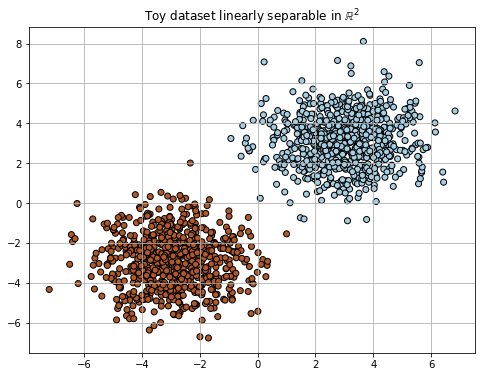

In [61]:
# load linearly separable dataset
X, y = make_blobs(n_samples=1500, centers=[(-3,-3),(3,3)], cluster_std=1.3, n_features=2, random_state=42)
y = 2 * y - 1

# visualize dataset
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Paired_r', edgecolors='k')
plt.title("Toy dataset linearly separable in $\mathbb{R}^2$")
plt.grid()
plt.show()

#### Running time

Examinons brièvement le temps de calcul pour ce dataset simple, selon si l'on met à jour uniquement les paramètres ou si l'on calcule en plus la log-posterior où les $\alpha$ à chaque itération.

Dans le cas où les poids sont stockés à chaque étape, ce sont uniquement des flottants stockés dans un array de taille fixé où l'allocation mémoire est déja pré-effectuée lors de l'initialisation `trackW = np.zeros(n_iter)`, ce n'est donc absolument pas couteux. Il n'est donc pas nécessaire de s'intéresser au temps de calcul lorsque l'on stocke les poids à chaque étape.

In [25]:
a = 1
b = 20
gamma = .6
batch_size = 5
beta_0 = np.random.rand(X.shape[1])
n_iter = 5000

# without computing log-posterior at each step  
print(f"Without computing any auxilliary quantity at each step (no log-posterior, no alpha):")
time.sleep(1)
_ = SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size)

# computing log-posterior at each step  
print(f"\nComputing just the log-posterior at each step:")
time.sleep(1)
betas, trackL = SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True)

# computing alphas at each step  
print(f"\nComputing just the alphas at each step:")
time.sleep(1)
betas, trackA = SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True)

# computing both alphas and log-posterior at each step  
print(f"\nComputing both the log-posterior and the alphas at each step:")
time.sleep(1)
betas, trackA, trackL = SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True, bool_trackA=True)

Without computing any auxilliary quantity at each step (no log-posterior, no alpha):


100%|██████████| 5000/5000 [00:00<00:00, 5048.41it/s]


Done in 0.99 s.

Computing just the log-posterior at each step:


100%|██████████| 5000/5000 [00:01<00:00, 4605.60it/s]


Done in 1.09 s.

Computing just the alphas at each step:


100%|██████████| 5000/5000 [00:01<00:00, 4668.21it/s]


Done in 1.07 s.

Computing both the log-posterior and the alphas at each step:


100%|██████████| 5000/5000 [00:01<00:00, 3304.08it/s]


Done in 1.51 s.


#### Examination of the convergence

In [26]:
a = 1
b = 20
gamma = .8
batch_size = 5
beta_0 = .5 * np.ones(X.shape[1])
n_iter = 5000

# computing both alphas and log-posterior at each step  
print(f"Computing both the log-posterior, the alphas and storing the weights at each step:")
time.sleep(1)
betas, trackA, trackW, trackL = SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True, bool_trackA=True, bool_trackW=True)

Computing both the log-posterior, the alphas and storing the weights at each step:


100%|██████████| 5000/5000 [00:01<00:00, 3320.17it/s]


Done in 1.51 s.


Vérifions alors que l'on optimise bien la log-posterior puis que l'on échantillonne selon la posterior. On devrait observer deux phases:

- une phase où la **log-posterior croît rapidement** (**optimisation phase**: SGD),

- une phase où l'algorithme se **stabilise dans une zone de forte probabilité de la posterior** distribution et échantillonne (**sampling phase**: Langevin). Attention!! Comme précedemment, le but n'est pas de stabiliser dans un unique mode de la posterior (comme le MAP) mais d'explorer les zones de forte probabilité, notamment dans le cas où la posterior serait multi-modale.

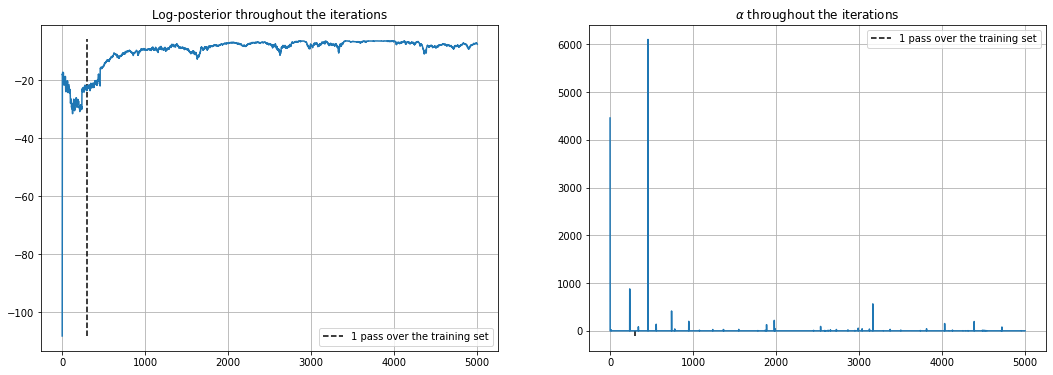

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(9*2, 6))
num_epoch = 1
num_samples = X.shape[0]

# plot log-posterior 
ax[0].vlines(num_epoch*num_samples/batch_size, ymin=trackL.min(), ymax=trackL.max()+.5, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[0].plot(trackL)
ax[0].set_title("Log-posterior throughout the iterations")
ax[0].legend()
ax[0].grid()

# plot alphas
ax[1].vlines(num_epoch*num_samples/batch_size, ymin=trackL.min(), ymax=trackL.max()+.5, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[1].plot(trackA)
ax[1].set_title("$\\alpha$ throughout the iterations")
ax[1].legend()
ax[1].grid()

plt.show()

On observe donc qu'après 200 itérations, i.e après **2 ~ 3 passages** sur le training set (batch_size=5, training_set_size=1000) et ces valeurs de $a=1$, $b=20$ et $\gamma=0.6$, on se stabilise plus ou moinds dans la **phase d'échantillonage**.

#### Examination of the sampling phase

Dans cette section, examinons la qualité de l'échantillonnage dans la phase d'échantillonnage, i.e vérifions que l'on peut bien **reconstruire la posterior** à l'aide d'un **histogramme 2-D des échantilllons** et vérifions que l'auto-corrélation des échantillons n'est pas trop grande.

Commençons tout d'abord par afficher la distribution posterior en surface plot et contour plot.

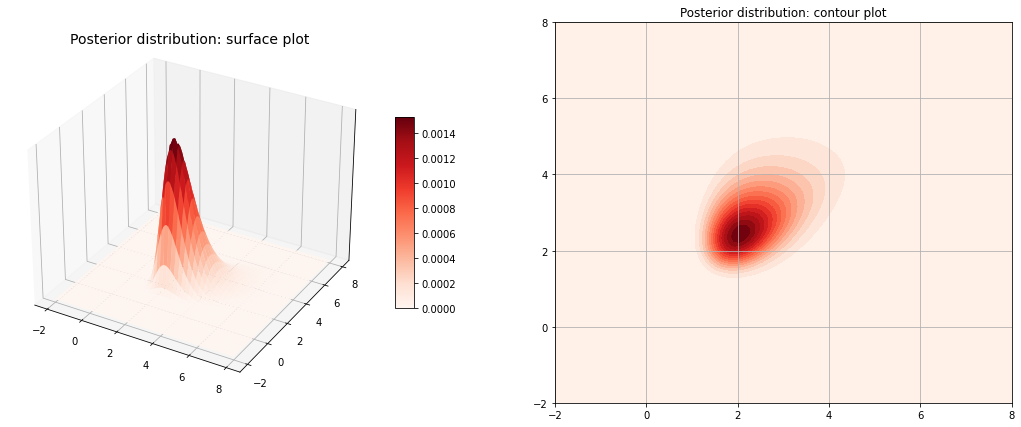

In [28]:
xs = np.linspace(-2, 8, 100)
ys = np.linspace(-2, 8, 100)
xx, yy = np.meshgrid(xs, ys, sparse=False, indexing='ij')
ZZ = np.array([np.exp(log_post_laplace(beta=[xss,yss], X=X, y=y)) for (xss,yss) in zip(xx.ravel(), yy.ravel())])
ZZ = ZZ.reshape(xx.shape)

fig = plt.figure(figsize=(9*2, 7))

# surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(xx, yy, ZZ, cmap='Reds')
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.axes.zaxis.set_ticks([])
ax.set_title("Posterior distribution: surface plot", y=1.03, fontsize=14)

# contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contourf(xs, ys, ZZ, 18, cmap='Reds',
            vmin=ZZ.min(), vmax=ZZ.max())
ax.grid()
ax.set_title("Posterior distribution: contour plot")
                     
plt.show()

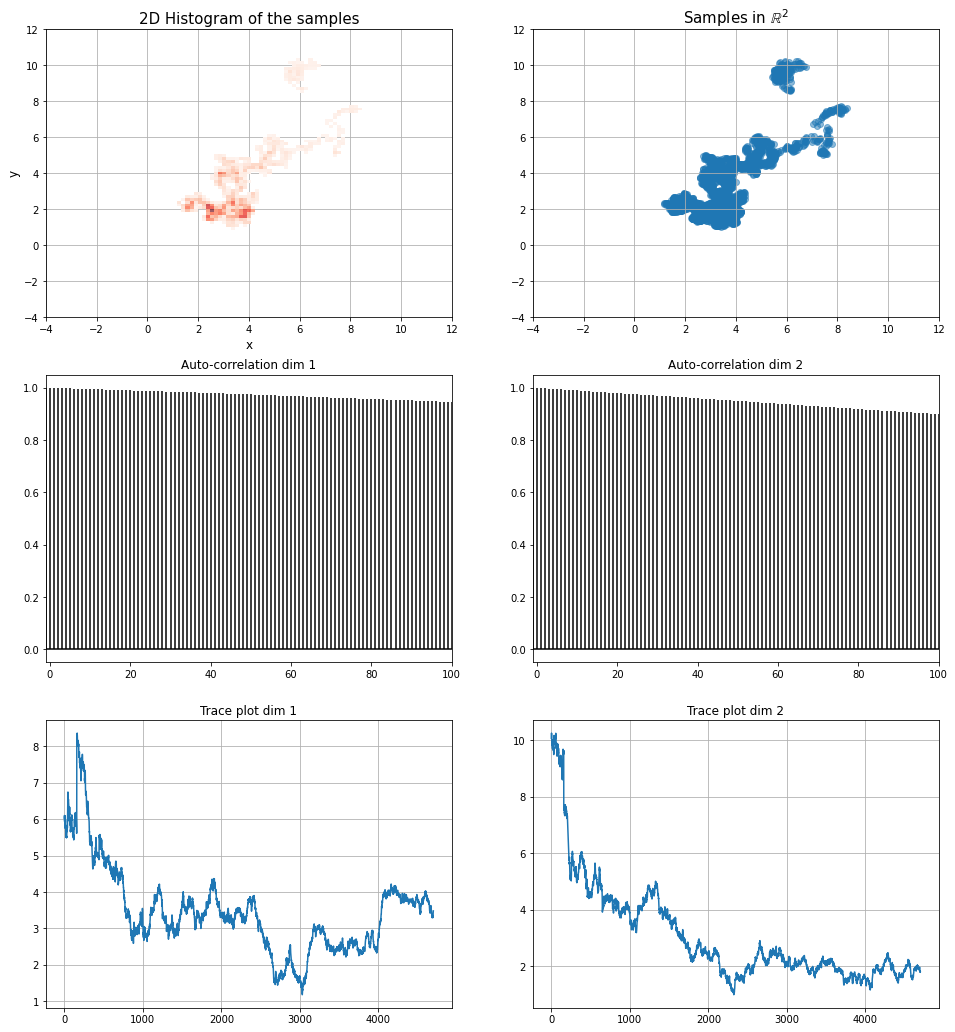

In [29]:
# get the samples
burn_in = int(num_epoch*num_samples/batch_size)
samples = betas[burn_in:]
xlim, ylim = (-4, 12), (-4, 12)

# get 2-D histogram of the samples
xs = np.linspace(xlim[0], xlim[1], 100)
ys = np.linspace(ylim[0], ylim[1], 100)
H, xs, ys = np.histogram2d(samples[:, 0], samples[:, 1], bins=(xs, ys))
H = H.T

fig, ax = plt.subplots(3, 2, figsize=(2*8, 3*6))
ax = ax.ravel()

ax[0].imshow(H, interpolation='nearest', origin='lower',
                   extent=[xs[0], xs[-1], ys[0], ys[-1]],
                   cmap="Reds", vmin=0., alpha=H, zorder=10, aspect='auto')
ax[0].grid()
ax[0].set_xlabel('x', fontsize=12)
ax[0].set_ylabel('y', fontsize=12)
ax[0].set_title('2D Histogram of the samples', fontsize=15)

ax[1].scatter(samples[:,0], samples[:,1], alpha=.5)
ax[1].set_title('Samples in $\mathbb{R}^2$', fontsize=15)
ax[1].set_xlim(xlim[0], xlim[1])
ax[1].set_ylim(ylim[0], ylim[1])
ax[1].grid()

# auto-correlation plot dim 1
ax[2].acorr(samples[:,0], maxlags=100, color='k')
ax[2].set_xlim(-1,100)
ax[2].set_title("Auto-correlation dim 1")

# auto-correlation plot dim 2
ax[3].acorr(samples[:,1], maxlags=100, color='k')
ax[3].set_xlim(-1,100)
ax[3].set_title("Auto-correlation dim 2")

# traceplot dim 1
ax[4].plot(np.arange(len(samples)), samples[:,0])
ax[4].set_title("Trace plot dim 1")
ax[4].grid()

# traceplot dim 2
ax[5].plot(np.arange(len(samples)), samples[:,1])
ax[5].set_title("Trace plot dim 2")
ax[5].grid()

plt.show()

On observe donc que l'échantillonnage est **correct** car on reconstruit (plus ou moins) bien les contour de la posterior avec l'histogramme 2D des échantillons. On observe toutefois que l'échantillonnage n'est **pas uniforme**, avec des **"trous" dans l'histogramme** 2D. De plus, l'échantillonnage n'est pas extrêmement efficace: les échantillons sont **très corrélés** et les **trace-plots** montrent une certaine **tendance globale**. 

Ceci était prévisible comme à mesure que l'on échantillonne, les **step-sizes diminuent** et donc les **échantillons** sont naturellement **plus corrélés** car le taux de mélange de la châine de markov induite par les échantillons diminue. On voit donc la **nécéssité** de **pondérer** l'importance les **échantillons par les step-sizes** dans les sommes de **Monte-Carlo** lorsque l'on approxime des espérances contre la posterior.

#### Predictive distribution and predictions

On peut alors calculer la predictive distribution et vérifier que l'on a bien une **incertitude maximale** lorsque l'on est **proche de la decision boundary** ou **loin du training set**. Notons que pour calculer la predictive distribution, qui est l'éspérance de la likelihood contre la posterior, on utilise la méthode proposée par l'artcile en **pondérant** l'importance de **chaque échantillon** dans la somme de Monte Carlo avec la **step-size** correspondante.

Afin d'obtenir des prédictions à partir de la predictive distribution, on prédit pour tout nouveau point $y^*$: $\mathrm{label}(y^*) = 2\cdot\mathbb{1}_{p(y^*|X, y, x^*) \geq p_0} - 1$ où $p_0 = 0.5$. La **decision boundary** est donc la **courbe de niveau 0.5** de la **predictive distribution**.

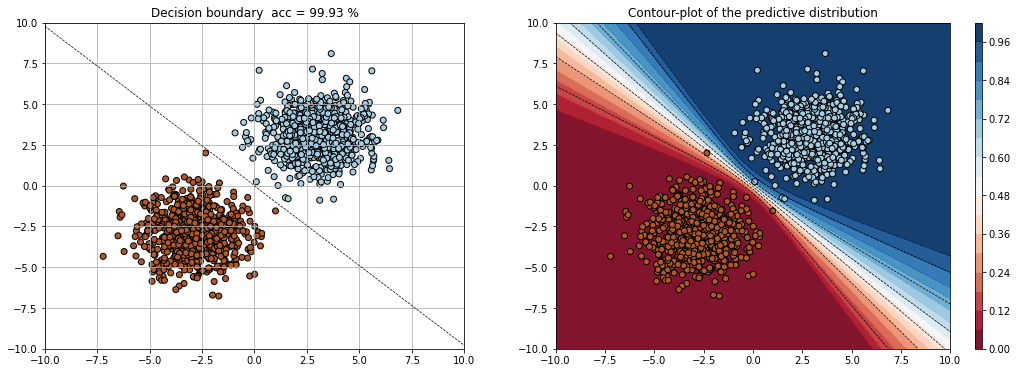

In [30]:
# approximation of the accuracy
beta = betas[-1]
acc = 100 * (np.sign(X @ beta) == y).mean()

# limits
xlim, ylim = (-4, 12), (-4, 12)

# contour of the predictive distribution
xs = np.linspace(-10, 10, 100)
ys = np.linspace(-10, 10, 100)
xx, yy = np.meshgrid(xs, ys, sparse=False, indexing='ij')
zz = np.array([[xss,yss] for (xss,yss) in zip(xx.ravel(), yy.ravel())])
ZZ = predictive_MC(X_new=zz, samples=betas, burn_in=burn_in, weights=trackW)
ZZ = ZZ.reshape(xx.shape)

#fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = plt.subplots(1, 2, figsize=(2*9, 6), gridspec_kw={"width_ratios": [.85, 1]})

# visualize decision boundary 
ax[0].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
ax[0].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7, levels=[.5])
ax[0].set_ylim(-10, 10)
ax[0].set_xlim(-10, 10)
ax[0].set_title("Decision boundary "+" acc = {} %".format(round(acc, 2)))
ax[0].grid()

# contour of the predictive distribution
cont = ax[1].contourf(xs, ys, ZZ, 18, cmap='RdBu',
            vmin=ZZ.min(), vmax=ZZ.max(), alpha=.95)
fig.colorbar(cont, aspect=50)
ax[1].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7)
ax[1].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
ax[1].set_title("Contour-plot of the predictive distribution");

plt.show()

Tout d'abord, on observe sur la figure de gauche que l'on on **sépare bien les deux classes**.  

Puis, sur la figure de droite, on observe exactement le comportement espéré: on a une incertitude maximale proche de la decision boundary et loin des données d'entrainement. Ceci est utile pour **lutter contre l'overfitting**: loin des données d'entrainement, il y a apriori peu de chance pour que le modèle classifie correctement les points.

### 1.4 Application on a toy (non-linearly spearable) dataset

Dans cette section, on teste notre implémentation de la SGLD sur un dataset **non-linéairement séparable** dans $\mathbb{R}^2$.  
Notre but est d'utiliser un feature mapping adéquat afin de bien séparer les données et de montrer l'efficacité des méthodes bayésiennes pour la **gestion de l'overfitting** dans ce genre de cas.  
De plus, c'est l'occasion d'utiliser la SGLD dans un espace de dimension supérieur à 2, puisque qu'on va se placer dans un espace de dimension supérieur à celui contenant les points.

#### Dataset visualization

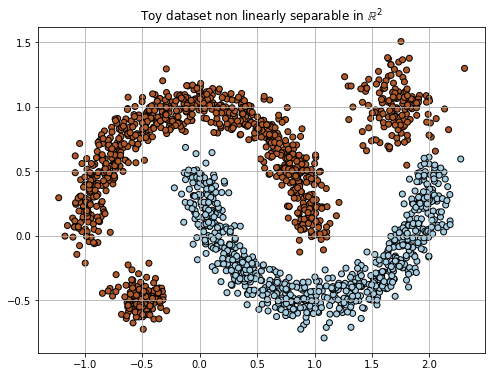

In [31]:
# load non linearly separable dataset
X, y = make_moons(n_samples=1500, noise=.09)
x1, y1 = multivariate_normal.rvs(mean=[1.7,1], cov=.03*np.eye(2), size=150), np.zeros(150)
x2, y2 = multivariate_normal.rvs(mean=[-.5,-.5], cov=.01*np.eye(2), size=150), np.zeros(150)
X = np.concatenate((X, x1, x2), axis=0)
y = np.concatenate((y, y1, y2), axis=0)
y = 2 * y - 1

# visualize dataset
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Paired_r', edgecolors='k')
plt.title("Toy dataset non linearly separable in $\mathbb{R}^2$")
plt.grid()
plt.show()

#### Application

Afin de rendre les données linéairement séparables, on **map les features** dans un espace de **dimension supérieure**. On considère la transformation $\phi : (x_1, x_2) \in \mathbb{R}^2 \mapsto (1, x_1, x_2, x_1x_2, x_1x_2^2, x_1^2x_2, x_1^2, x_2^2, x_1^3, x_2^3) \in \mathbb{R}^{10}$, puis on map chacun des points du training set de $\mathbb{R}^2$ dans $\mathbb{R}^{10}$.  
On effectue ensuite la classification dans $\mathbb{R}^{10}$ avec cette nouvelle représentation des points (ce qui revient à utiliser un kernel polynomial de degré 3).

In [32]:
# polynomial transformation of the features
poly = PolynomialFeatures(3)
phi_X = poly.fit_transform(X)
print(f"Number of dimension of the new covariates: {phi_X.shape[1]}.")

Number of dimension of the new covariates: 10.


In [33]:
a = .1
b = 40
gamma = .7
batch_size = 10
beta_0 = np.ones(phi_X.shape[1])
n_iter = 5000

# without computing log-posterior at each step  
print(f"Without computing any auxilliary quantity at each step (no log-posterior, no alpha):")
time.sleep(1)
_ = SGLD_logreg(phi_X, y, n_iter, a, b, gamma, beta_0, batch_size)

# computing both alphas and log-posterior at each step  
print(f"Computing both the log-posterior, the alphas and storing the weights at each step:")
time.sleep(1)
betas, trackA, trackW, trackL = SGLD_logreg(phi_X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True, bool_trackA=True, bool_trackW=True)

Without computing any auxilliary quantity at each step (no log-posterior, no alpha):


100%|██████████| 5000/5000 [00:00<00:00, 5679.51it/s]


Done in 0.88 s.
Computing both the log-posterior, the alphas and storing the weights at each step:


100%|██████████| 5000/5000 [00:01<00:00, 2772.30it/s]


Done in 1.81 s.


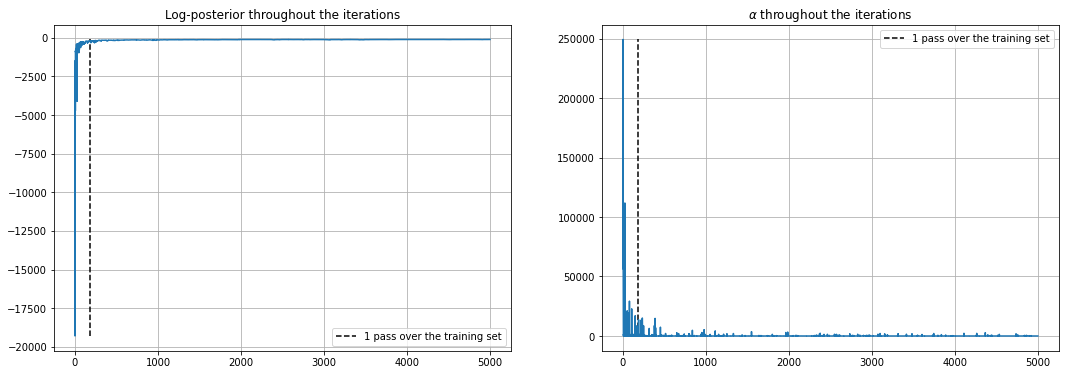

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(9*2, 6))
num_epoch = 1
num_samples = X.shape[0]
burn_in = int(num_epoch*num_samples/batch_size)

# plot log-posterior 
ax[0].vlines(burn_in, ymin=trackL.min(), ymax=trackL.max()+.5, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[0].plot(trackL)
ax[0].set_title("Log-posterior throughout the iterations")
ax[0].legend()
ax[0].grid()

# plot alphas
ax[1].vlines(burn_in, ymin=trackA.min(), ymax=trackA.max()+.5, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[1].plot(trackA)
ax[1].set_title("$\\alpha$ throughout the iterations")
ax[1].legend()
ax[1].grid()

plt.show()

#### Predictive distribution and predictions

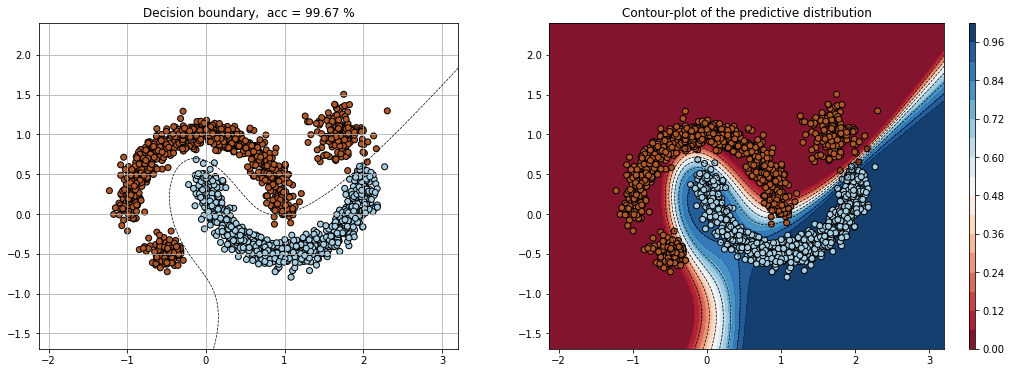

In [35]:
# approximation of the accuracy
beta = betas[-1]
acc = 100 * (np.sign(phi_X @ beta) == y).mean()

xlim, ylim = (X[:,0].min()-.9, X[:,0].max()+.9), (X[:,1].min()-.9, X[:,1].max()+.9)

# contour of the predictive distribution
xs = np.linspace(xlim[0], xlim[1], 100)
ys = np.linspace(ylim[0], ylim[1], 100)
xx, yy = np.meshgrid(xs, ys, sparse=False, indexing='ij')
zz = np.array([[xss,yss] for (xss,yss) in zip(xx.ravel(), yy.ravel())])
phi_zz = poly.transform(zz)
ZZ = predictive_MC(X_new=phi_zz, samples=betas, burn_in=burn_in, weights=trackW)
ZZ = ZZ.reshape(xx.shape).T

#fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = plt.subplots(1, 2, figsize=(2*9, 6), gridspec_kw={"width_ratios": [.85, 1]})

# visualize decision boundary 
ax[0].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
#x = np.linspace(-10, 10, 10)
#ax[0].plot(x, f(x), linestyle='--', color='k')
ax[0].set_ylim(ylim[0], ylim[1])
ax[0].set_xlim(xlim[0], xlim[1])
ax[0].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7, levels=[0.5])
ax[0].set_title("Decision boundary, "+" acc = {} %".format(round(acc, 2)))
ax[0].grid()

# contour of the predictive distribution
cont = ax[1].contourf(xs, ys, ZZ, 18, cmap='RdBu',
            vmin=ZZ.min(), vmax=ZZ.max(), alpha=.95)
fig.colorbar(cont, aspect=50)
ax[1].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7)
ax[1].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
ax[1].set_title("Contour-plot of the predictive distribution");

plt.show()

Tout d'abord, on observe que le données sont bien séparées à l'aide du feature mapping de $\mathbb{R}^3$ dans $\mathbb{R}^{10}$. De plus, on observe également le bénéfice des méthodes bayésiennes: la predictive distribution montre des zones de grande incertitude, i.e $p(y^*|x^*, X, y) \approx 0.5$. Ceci montre bien en quoi utiliser la SGLD (pour échantillonner selon la posterior) peut nous aider à **lutter** contre **l'overfitting**.

### 1.5 Application on a real dataset

#### Data loading

Pour tester notre modèle sur des **données plus complexes**, on utilise le dataset: https://archive.ics.uci.edu/ml/datasets/HTRU2#. 
C'est un dataset contetant **17,898 échantillons**, chacun ayant **8 attributs** (features) et une **classe binaire** (stable, unstable). Il ne contient pas de valeurs manquantes.

In [37]:
# load the dataset
data = pd.read_csv("HTRU_2.csv", header=None)
print(f"Number of instances: {data.shape[0]}")
print(f"Number of attributes: {data.shape[1]-1}")
print(f"Number of classes: {len(np.unique(data[data.columns[-1]].values))}\n")
data.head()

Number of instances: 17898
Number of attributes: 8
Number of classes: 2



,0,1,2,3,4,5,6,7,8
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


#### Data pre-processing

In [38]:
# pre-process data
X_ = data[data.columns[:-1]].values

# pre-process labels
y_ = 2 * (data[data.columns[-1]]==0).values - 1

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=.25, random_state=42)

print(f"Number of training examples: {len(X_train)}.")
print(f"Number of testing examples: {len(X_test)}.")

Number of training examples: 13423.
Number of testing examples: 4475.


Après quelques tests, nous avons réalisé qu'il était nécessaire de **centrer et normaliser les données**. En effet, si cette étape n'est pas réalisée, la phase d'optimisation est extrêmement chaotique et diverge pour certaines éxécutions de l'algorithme. On pré-traite donc les données afin que chaque **feature** ait une **moyenne nulle** et un **écart type unitaire**.

Nous pouvons intepréter cette étape comme l'étape de **"pre-conditionning"** décrite dans l'article, où l'on multiplie les gradient par une matrice $M$, ce qui revient à multiplier la matrice des données par cette matrice par formule de la chaîne.

In [39]:
# fit scaler on training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# scale test data
X_test = scaler.transform(X_test)

#### Application

In [40]:
a = .01
b = 30
gamma = .7
batch_size = 10
beta_0 = np.zeros(X_train.shape[1])
n_iter = 5000

# without computing log-posterior at each step  
print(f"Without computing any auxiliary quantity at each step (no log-posterior, no alpha):")
time.sleep(1)
_ = SGLD_logreg(X_train, y_train, n_iter, a, b, gamma, beta_0, batch_size)

# computing both alphas and log-posterior at each step  
print(f"Computing both the log-posterior, the alphas and storing the weights at each step:")
time.sleep(1)
betas, trackA, trackW, trackL = SGLD_logreg(X_train, y_train, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True, bool_trackA=True, bool_trackW=True)

Without computing any auxiliary quantity at each step (no log-posterior, no alpha):


100%|██████████| 5000/5000 [00:00<00:00, 5902.98it/s]


Done in 0.85 s.
Computing both the log-posterior, the alphas and storing the weights at each step:


100%|██████████| 5000/5000 [00:02<00:00, 1843.46it/s]


Done in 2.72 s.


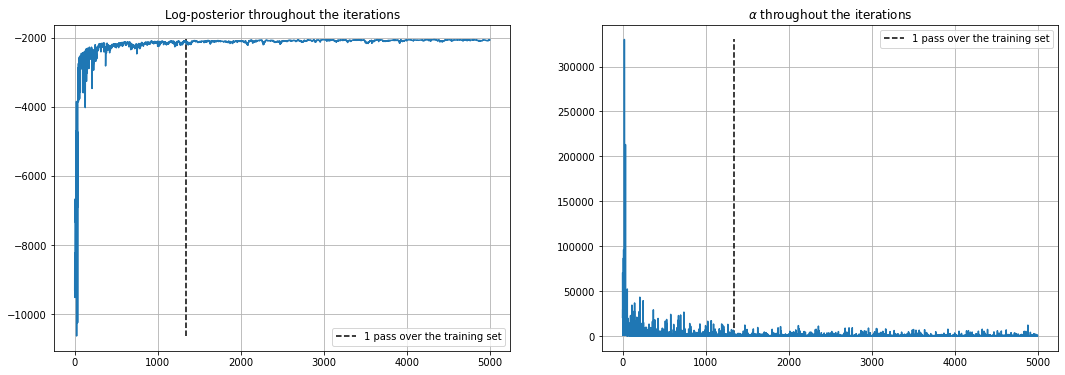

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(9*2, 6))
num_epoch = 1
num_samples = X_train.shape[0]

# plot log-posterior 
ax[0].vlines(num_epoch*num_samples/batch_size, ymin=trackL.min(), ymax=trackL.max()+.5, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[0].plot(trackL)
ax[0].set_title("Log-posterior throughout the iterations")
ax[0].legend()
ax[0].grid()

# plot alphas
ax[1].vlines(num_epoch*num_samples/batch_size, ymin=trackA.min(), ymax=trackA.max()+.5, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[1].plot(trackA)
ax[1].set_title("$\\alpha$ throughout the iterations")
ax[1].legend()
ax[1].grid()

plt.show()

#### Predictions and learning curves

On étudie ici l'évolution de l'**accuracy à chaque itération** $t$ lorsque l'on prend comme point estimate $\hat{\beta} = \beta_t$. On calule donc à chaque itération l'erreur de classification $\mathrm{acc} = \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{\{\mathrm{sign}(\beta_t^{\top}x_i = y_i\}}$.

On espère alors que l'accuracy sur le training set et le testing se **stablise assez rapidement** (optimisation phase) avant d'entrer dans une longue phase où elle est assez haute et **n'évolue plus** (sampling phase).

In [42]:
# get a point estimates of the parameter (naive strategy)
beta = betas[-1]
burn_in = int(num_epoch*num_samples/batch_size)

# get the accuracy on the training set
acc_train = 100 * (np.sign(X_train @ beta) == y_train).mean()
print(f"Accuracy on the training set: {round(acc_train, 2)}%")

# get the accuracy on the testing set
acc_test = 100 * (np.sign(X_test @ beta) == y_test).mean()
print(f"Accuracy on the testing set: {round(acc_test, 2)}%")

Accuracy on the training set: 96.57%
Accuracy on the testing set: 96.74%


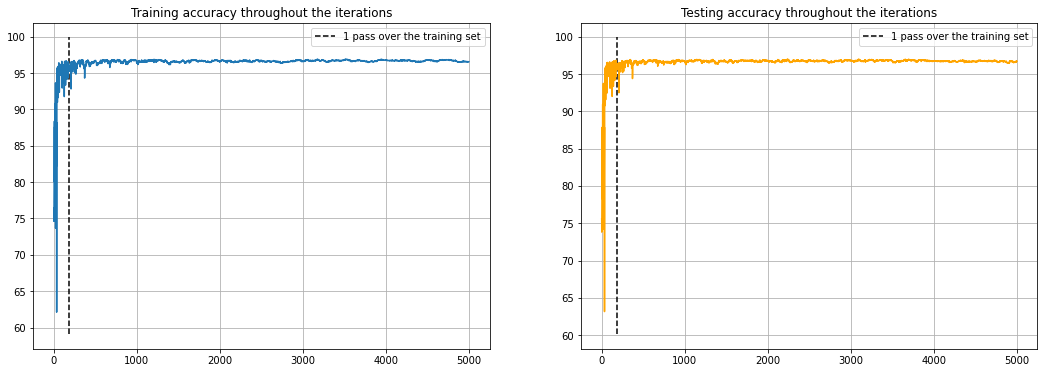

In [43]:
# get the training accuracy at each iteration 
accs_train = get_acc_iter(X_train, y_train, samples=betas)

# get the testing accuracy at each iteration 
accs_test = get_acc_iter(X_test, y_test, samples=betas)

fig, ax = plt.subplots(1, 2, figsize=(9*2, 6))
num_epoch = 1
num_samples = X.shape[0]

# plot training accuracy throughout the iterations
ax[0].vlines(num_epoch*num_samples/batch_size, ymin=accs_train.min()-3, ymax=accs_train.max()+3, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[0].plot(accs_train)
ax[0].set_title("Training accuracy throughout the iterations")
ax[0].legend()
ax[0].grid()

# plot testing accuracy throughout the iterations
ax[1].vlines(num_epoch*num_samples/batch_size, ymin=accs_test.min()-3, ymax=accs_train.max()+3, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[1].plot(accs_test, c='orange')
ax[1].set_title("Testing accuracy throughout the iterations")
ax[1].legend()
ax[1].grid()

plt.show()

#### Predictive distribution and Bayesian benefits 

Il est à présent interessant de tirer profit des méthodes Bayesiennes.  

En effet, calculons la predictive distribution de chacun des testing examples afin d'analyser la robustesse de notre prédiction. Logiquement, pour un point donné on devrait observer:

- une probabilité **proche de 1** lorsque le **label** prédit est **1** et qu'il est **bien classifié**, 

- une probabilité **proche de 0** lorsque le **label** prédit est **-1** et qu'il est **bien classifié**,

- une probabilité **proche de 0.5** lorsque le **label** est **mal-classifié**.

Afin d'obtenir des prédictions à partir de la predictive distribution, on prédit pour tout nouveau point $y^*$: $\mathrm{label}(y^*) = 2\cdot\mathbb{1}_{p(y^*|X, y, x^*) \geq p_0} - 1$ où $p_0 = 0.5$.

In [44]:
# get predictive distribution for each testing examples
pred_test = predictive_MC(X_new=X_test, samples=betas, burn_in=burn_in, weights=trackW)

# get a hard prediction
y_pred = 2 * (pred_test >= .5) -1

# get misclassified examples
idxs_misclass = np.where(y_pred != y_test)[0]

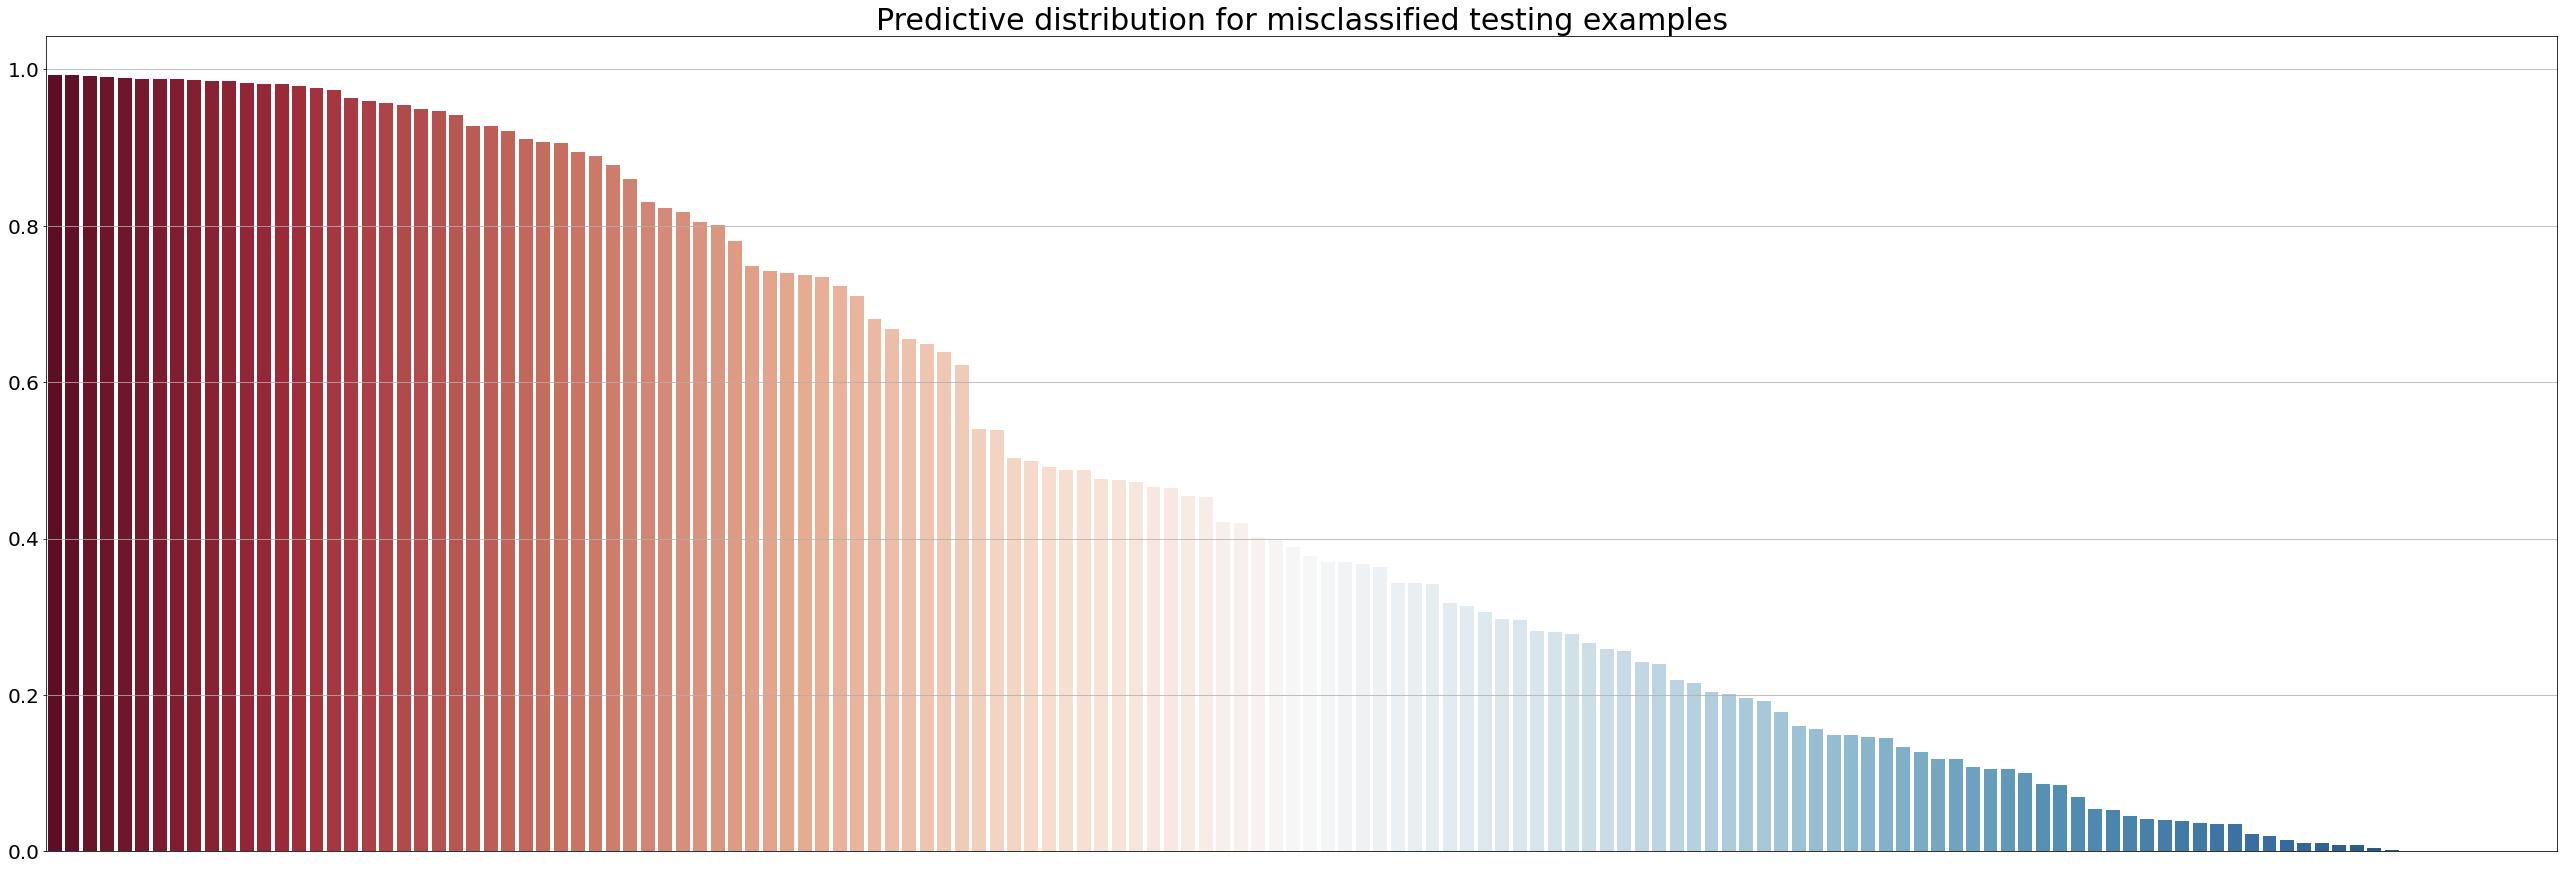

In [45]:
fig, ax = plt.subplots(figsize=(45,15))
bar = sns.barplot(y=np.flip(np.sort(pred_test[idxs_misclass])), 
            x=[str(x) for x in idxs_misclass[np.flip(np.argsort(pred_test[idxs_misclass]))]], 
            palette='RdBu', orient='v', ax=ax);
ax.axes.xaxis.set_ticks([])
ax.tick_params(axis='y', which='major', labelsize=20)
ax.set_title("Predictive distribution for misclassified testing examples", fontsize=30)
ax.grid();

Le graphe ci dessus montre, par ordre de **predictive distribution** decroissante, la predictive distribution pour chacun des testing examples mal-classifié. 
On espererait **idéalement** que ces dernières soient aux alentours de **0.4 ~ 0.6**, mais ce n'est pas le cas.  

On observe notamment des probabilités très proches de 1 (forte confiance en une prédiction d'un label par 1) et des probabilités très proches de 0 (forte confiance en une prédiction d'un label par 1).

Afin d'avoir un **critère de robustesse** quant à la gestion de l'incertitude pour les mauvaises prédictions, on peut calculer un critère défini à partir l'**entropie binaire** de la **predictive distribution** sur les **testing examples mal-classifiés**.  

En effet, notons $\mathcal{X}^* = \{x^*_{1}, ..., x^*_{p} \}$ les testing examples mal classifiés, i.e les testing examples tels que $2\cdot\mathbb{1}_{p(y^*|X, y, x^*) \geq 0.5} - 1 \neq y^*$.  

Comme on l'a précisé, on voudrait idéalement que ces points aient des predictive distributions d'incertitude maximale, i.e de variance maximale, soit que $\forall i \in \{1,...,p\}, \, p(y_i^*=1|X, y, x_i^*) \approx p(y_i^*=0|X, y, x_i^*) \approx 0.5$ comme on manipule des varaibles aléatoires binaires à valeur dans $\{-1, 1\}$.  

Or l'entropie d'une variable aléatoire $X$ à valeur dans $\{-1, 1\}$ est maximale lorsque $\mathbb{P}(X=1) = \mathbb{P}(X=-1) = 0.5$. Ainsi, en utilisant la moyenne de l'entropie binaire pour chacun des testing examples mal classifiés: $H(\mathcal{X}^*) = \frac{1}{p} \sum_{i=1}^p - p(y_i^*=1|X, y, x_i^*) \, \log(p(y_i^*=1|X, y, x_i^*)) - (1-p(y_i^*=1|X, y, x_i^*)) \, \log(1 - p(y_i^*=1|X, y, x_i^*))$, ce critère permet de mesurer la gestion de l'incertitude pour les mauvaises prédictions.  

Plus ce **critère** est **grand**, plus le modèle est **indécis** lorsqu'il effectue des **mauvaises prédictions** et donc plus le modèle est **robuste** et on tend vers le comportement souhaité. Inversément, plus ce **critère** est **faible**, plus le **modèle** est **confiant** lorsqu'il effectue des **mauvaises prédictions** et donc le modèle n'est **pas robuste**.

In [46]:
# get robusteness criterion 
crit = get_criterion_ent(pred_distrib=pred_test, idxs_misclass=idxs_misclass)
print(f"Robustness criterion: {round(crit, 5)}.")

Robustness criterion: 0.37783.


Il sera alors interessant de **comparer ce résultat** avec **d'autres méthodes** d'échantillonnage.

## 2 Adaptative Symmetric Random Walk

Dans cette section, on va utiliser une **autre méthode** d'échantillonnage selon la posterior et comparer les résultats à ceux obtenus précedemment avec la SGLD. Nous allons utiliser une méthode d'**échantillonage pure**, où nous n'avons pas de phase d'optimisation de la log-posterior: un **adaptive symmetric random walk** avec une **proposal distribution gaussienne**. La différence avec un symmetric random walk simple est que l'on **apprend la covariance de la proposal distribution** au cours des itérations **à partir des échantillons générés**.

### 2.1 A brief summary of the method

#### Reminder on symmetric random walk

On rappelle le principe du symmetric random walk classique où l'on échantillonne selon une **loi cible** $\pi$ avec une proposal distribution gaussienne $q_{\Gamma}(\cdot, x) \sim \mathcal{N}(x, \Gamma)$, à **chaque itération** $t$:

- on génère un candidat $\hat{\theta}_t \sim q_{\Gamma}(\cdot,\theta_{t-1})$,

- on calcule la probabilité d'acceptation du candidat $\alpha(\hat{\theta}_t, \theta_{t-1}) = \mathrm{min}(1, \pi(\hat{\theta}_t) \, / \, \pi(\theta_{t-1})$,

- on génère $u \sim U([0, 1])$ et $\theta_t \leftarrow \hat{\theta}_t$ si $\alpha \geq u$ sinon $\theta_t \leftarrow \theta_{t-1}$.

#### With adaptative covariance

On note $(\mu_t, \Gamma_t)_{t\geq0}$ les paramètres à l'itération $t$. Pour $(\Delta_t)_{t\geq0}$ une suite de gain décroissante vers 0 mais telle que $\sum_t \Delta_t = + \infty$ (pour la convergence de approximation stochastique, comme avec $(\epsilon_t)_{t\geq 0}$ pour la SGLD), à chaque itération $t$:

- on génère $X_t$ selon une étape de symetric random walk classique de proposal $q_{\Gamma}(\cdot,\Gamma)$ (comme décrit ci-dessus),

- on met à jour $\mu$ : $\mu_{t+1} = \mu_t + \Delta_{t+1} \, (\theta_{t+1} - \mu_t)$,

- on met à jour $\Gamma$ : $\Gamma_{t+1} = \Gamma_t + \Delta_{t+1} \, \left((\theta_{t+1} - \mu_t) \, (\theta_{t+1} - \mu_t)^{\top} - \Gamma_{t}\right)$.

On utilisera par la suite $(\Delta_t)_{t\geq0} = (\frac{1}{t^\gamma})_{t\geq0}$ où $\gamma \in (0.5,1]$ sera choisit empiriquement comme pour la SGLD.

#### Why don't we use a simple symmetric random walk ?

Un symmetric random walk classique est très efficace lorsque la distribution est **sensiblement gaussienne**, i.e lorsque les **sublevel sets** de la **densité cible** sont **ellispoïdaux**.  

Ici, les plots précédents montrent que les **sub-level sets** de la posterior distribution $p(\beta|X,y)$ sont assez **anisotropes** et étirés selon une certaine direction: la prior de laplace entaîne une queue lourde pour la posterior.  

Pour pouvoir échantillonner efficacement dans **la queue de la distribution**, on devrait utiliser une **proposal** distribution de **grande variance**, ce qui entrainerait **beacoup de rejet** et donc un algorithme **plus long** pour obtenir assez d'échantillons pour approximer des predictive distributions.

L'**adaptative** symmetric random walk est alors utilisé pour **pouvoir échantillonner** dans la **queue de la distribution** tout en **évitant d'avoir un taux d'acceptation trop faible**  car la covariance de la proposal distribution est apprise au cours des itérations afin de s'adapter aux différentes zones dans lesquelles on échantillonne. 

#### What should we expect w.r.t SGLD ?

Comme on utilise ici une méthode MCMC classique, chaque itération nécessite de manipuler tout le training set: on doit calculer la probabilité d'acceptation  des candidats à chacune des itérations, qui est un rapport de posterior distribution donc qui nécessite tous les training examples (pas de calculs par batch). On devrait donc avoir un **échantilonnage plus lent**, surtout lorsque le dataset est grand. Il sera donc interessant de comparer les running times, surtout sur de grand datasets.

De plus, comme on utilise ici une méthode purement axé échantillonage (et pas optimisation), on devrait avoir un **échantillonnage de meilleur qualité** (échantillons moins corrélés, trace-plots plus uniformes). 

### 2.2 Implementation

Une implémentation du symetric random walk classique est également fournie. Nous l'utiliserons plus tard dans un contexte précis.

In [48]:
def srwMH(n_samples, cov, init_sample, target, dim=2):
    '''
    Symetric Random Walk Hasting Metropolis algorithm.
    Parameters:
      n_samples: int, number of samples to generate
      cov: np.array, covariance of the proposal distribution
      init_sample: np.array, initial sample
      target: callable, target distrbution
    Returns:
      samples: np.array, generated samples
      accept_ratio: float, acceptance ratio (#{accepted_candidates} / #{number_iterations})
      alphas: np.array, acceptance probability at each step
    '''
    start = time.time()
    samples = np.vstack((init_sample, np.zeros((n_samples, dim))))
    alphas = np.zeros(n_samples)
    accept_bools = np.zeros(n_samples)
    
    for ii in tqdm(range(n_samples)):
        
        # draw a candidate
        current = samples[ii]
        proposal = multivariate_normal(mean=current, cov=cov)
        cand = proposal.rvs(size=1)
        
        # compute acceptance ratio
        alpha = min(1, target(cand) / target(current)) if target(current)>0 else 1
        alphas[ii] = alpha
        
        # accept with proba alpha
        u = np.random.rand()
        accept_bool = (alpha > u)
        accept_bools[ii] = accept_bool
        if accept_bool:
            samples[ii+1] = cand     # accept candidate
        else:
            samples[ii+1] = current   # reject candidate
                                
    # compute acceptance ratio
    accept_ratio = np.mean(accept_bools)
    
    end = time.time()
    time.sleep(.1)
    print(f"Done in {round(end-start, 2)} s.")
    
    return samples, accept_ratio, alphas

In [49]:
def adaptive_srwMH(n_samples, init_mu, init_cov, init_sample, gamma, target, c=1, dim=2, reg=1):
    '''
    Adaptive symetric Random Walk Hasting Metropolis algorithm.
    Parameters:
      n_samples: int, number of samples to generate
      init_mu: np.array, initial mean of the proposal distribution
      init_cov: np.array, initial covariance of the proposal distribution
      init_sample: np.array, initial sample
      gamma: float, controls the decreasing speed of the step size
      c: float, weight to ponderate proposal covariance at each iteration (advanced setting, keep it to 1 in general)
      target: callable, target distrbution
      reg: float, used to control singular covariance matrices problem
    Returns:
      samples: np.array, generated samples
      accept_ratio: float, acceptance ratio (#{accepted_candidates} / #{number_iterations})
      alphas: np.array, acceptance probability at each step
    '''
    start = time.time()
    samples = np.vstack((init_sample, np.zeros((n_samples, dim))))
    alphas = np.zeros(n_samples)
    accept_bools = np.zeros(n_samples)
    
    # initialize parameters
    mus = np.vstack((init_mu, np.zeros((n_samples, dim))))
    covs = np.vstack((init_cov[None, :], np.zeros((n_samples, dim, dim))))
    
    for ii in tqdm(range(n_samples)):
        
        # draw a candidate
        current = samples[ii]
        proposal = multivariate_normal(mean=current, cov=c*covs[ii])
        cand = proposal.rvs(size=1)
        
        # compute acceptance ratio
        alpha = min(1, target(cand) / target(current)) if target(current)>0 else 1
        alphas[ii] = alpha
        
        # accept with proba alpha
        u = np.random.rand()
        accept_bool = (alpha > u)
        accept_bools[ii] = accept_bool
        if accept_bool:
            samples[ii+1] = cand     # accept candidate
        else:
            samples[ii+1] = current   # reject candidate
                                
        # update parameters
        mus[ii+1] = mus[ii] + (1/((ii+1)**gamma)) * (samples[ii+1] - mus[ii])
        covs[ii+1] = covs[ii] + (1/((ii+1)**gamma)) * ((samples[ii+1] - mus[ii]) @ (samples[ii+1] - mus[ii]).T - covs[ii]) \
                                                                                  + reg * (1/((ii+1)**(gamma))) * np.eye(dim)                                                                                                    
            
    # compute acceptance ratio
    accept_ratio = np.mean(accept_bools)
    
    end = time.time()
    time.sleep(.1)
    print(f"Done in {round(end-start, 2)} s.")
    
    return samples, accept_ratio, alphas

### 2.3 Application on a toy (linearly separable) dataset

On conserve ici le même dataset linéairement spéarable dans $\mathbb{R}^2$ que précedemment afin de tester notre implémentation. 

#### Sampling

On échantillonne afin d'avoir un **taux d'acceptation** autour de **30%**, afin d'explorer efficacement le support de la posterior.

In [50]:
# make sure we manipulate the good dataset
X, y = make_blobs(n_samples=1500, centers=[(-3,-3),(3,3)], cluster_std=1.3, n_features=2, random_state=42)
y = 2 * y - 1

In [51]:
# target distribution
target = lambda beta: np.exp(log_post_laplace(beta, X, y))

dim = X.shape[1]
n_samples = 5000
init_cov =  2 * np.eye(dim)
init_mu = np.zeros(dim)
init_sample = np.ones(dim)
gamma = .7

samples, accept_ratio, alphas = adaptive_srwMH(n_samples, init_mu, init_cov, init_sample, gamma, target=target)
print("Acceptance ratio: {}".format(accept_ratio))

100%|██████████| 5000/5000 [00:02<00:00, 2236.84it/s]

Done in 2.24 s.
Acceptance ratio: 0.3118


On observe donc un temps de calcul supérieur à celui obtenu avec SGLD. En effet, pour obtenir 5000 échantillons (sans calculer les log-posterior et les $\alpha$ à chaque itération), on avait un temps de calcul autour de 0.85 s.  

En considérant que le **burn-in** (temps d'attente afin que l'on échantillonne effectivement selon la posterior) des deux méthodes est **sensiblement le même**, on obtient donc, comme prévu, que la **SGLD** est **plus rapide** (plus de 2 fois plus rapide !!).

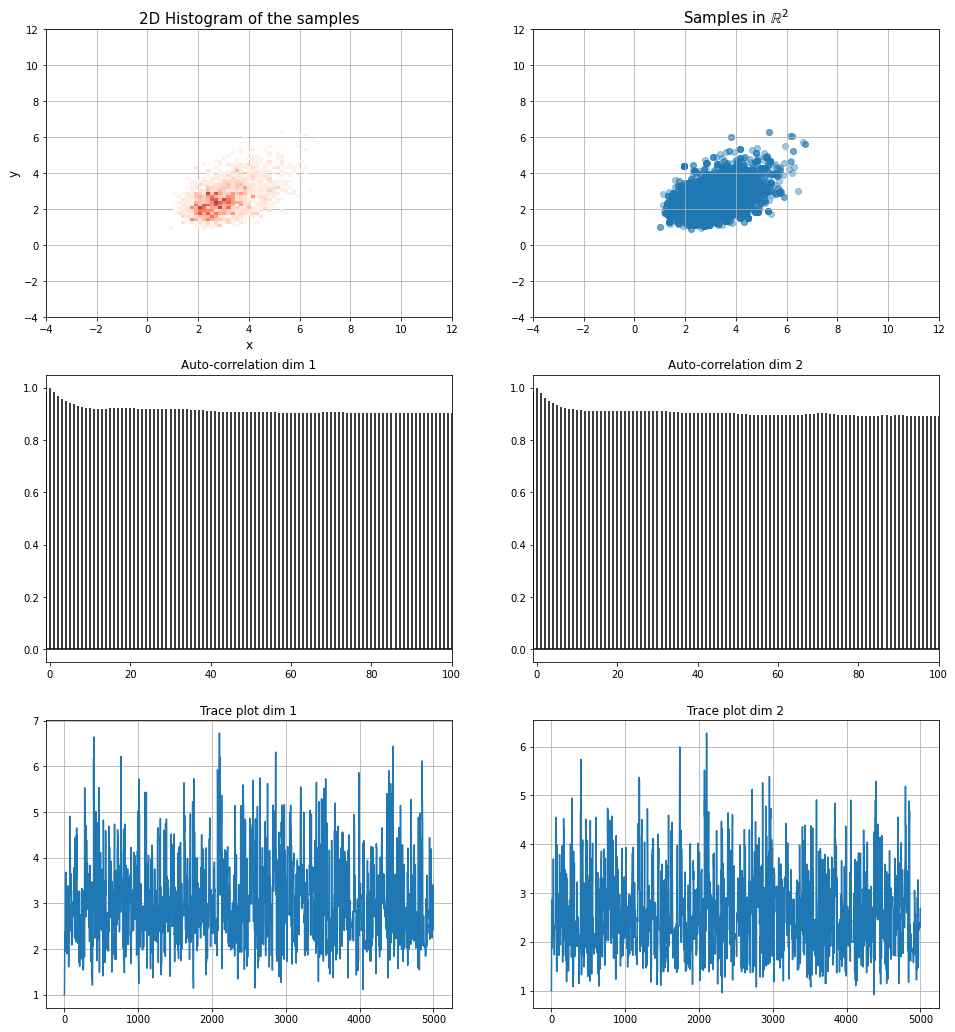

In [52]:
# get the samples
xlim, ylim = (-4, 12), (-4, 12)

# get 2-D histogram of the samples
xs = np.linspace(xlim[0], xlim[1], 100)
ys = np.linspace(ylim[0], ylim[1], 100)
H, xs, ys = np.histogram2d(samples[:, 0], samples[:, 1], bins=(xs, ys))
H = H.T

fig, ax = plt.subplots(3, 2, figsize=(2*8, 3*6))
ax = ax.ravel()

ax[0].imshow(H, interpolation='nearest', origin='lower',
                   extent=[xs[0], xs[-1], ys[0], ys[-1]],
                   cmap="Reds", vmin=0., alpha=H, zorder=10, aspect='auto')
ax[0].grid()
ax[0].set_xlabel('x', fontsize=12)
ax[0].set_ylabel('y', fontsize=12)
ax[0].set_title('2D Histogram of the samples', fontsize=15)

ax[1].scatter(samples[:,0], samples[:,1], alpha=.4)
ax[1].set_title('Samples in $\mathbb{R}^2$', fontsize=15)
ax[1].set_xlim(xlim[0], xlim[1])
ax[1].set_ylim(ylim[0], ylim[1])
ax[1].grid()

# auto-correlation plot dim 1
ax[2].acorr(samples[:,0], maxlags=100, color='k')
ax[2].set_xlim(-1,100)
ax[2].set_title("Auto-correlation dim 1")

# auto-correlation plot dim 2
ax[3].acorr(samples[:,1], maxlags=100, color='k')
ax[3].set_xlim(-1,100)
ax[3].set_title("Auto-correlation dim 2")

# traceplot dim 1
ax[4].plot(np.arange(len(samples)), samples[:,0])
ax[4].set_title("Trace plot dim 1")
ax[4].grid()

# traceplot dim 2
ax[5].plot(np.arange(len(samples)), samples[:,1])
ax[5].set_title("Trace plot dim 2")
ax[5].grid()

plt.show()

Comme prévu, on observe un **échantillonnage plus efficace** en termes d'auto-corrélation et de trace-plots: les échantillons sont un peu moins corrélés que précédemment et les trace-plots ne présentent pas de tendance globale.

En termes de parcours du **support de la distribution**, il semble que l'adaptive symetric random walk parcourt celui-ci de façon **plus uniforme**, i.e on n'observe **pas de "trous"** dans l'**histogramme** 2D des échantillons comme c'était le cas avec la SGLD et cet histogramme ressemble fortement aux contour plot de la posterior. 

**Remarque subsidiaire:**  
En revanche, on parcourt un peu moins bien la queue de la distribution qu'avec la SGLD car on observe moins d'échantillons s'écartant vraiment du mode. Ceci est du au fait qu'avec une SGLD on accepte tous les candidats à chaque étape en partant du constat que $\epsilon_t \rightarrow 0$. Par ailleurs, cet aspect crée avec la SGLD de nombreux échantillons qui pourraient être vus comme des outliers et que l'on ne retrouve pas avec l'adaptive symmetric random walk.

#### Predictions and predictive distributions

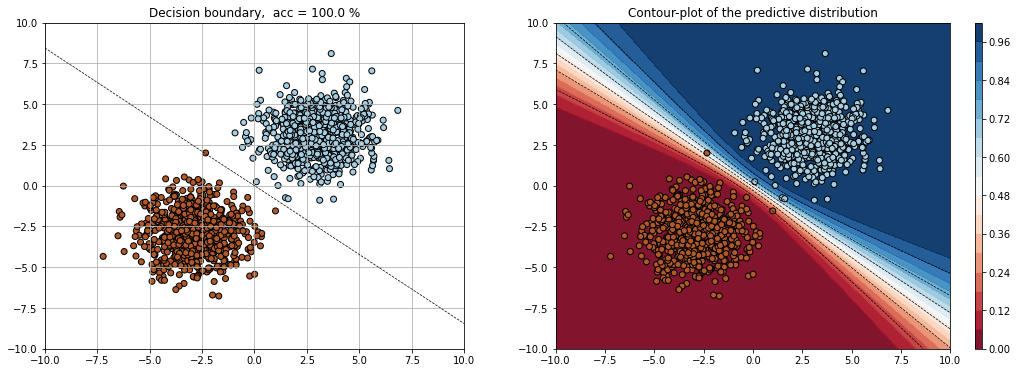

In [53]:
# approximation of the acuracy 
beta = samples[-1]
acc = 100 * (np.sign(X @ beta) == y).mean()

# contour of the predictive distribution
xs = np.linspace(-10, 10, 100)
ys = np.linspace(-10, 10, 100)
xx, yy = np.meshgrid(xs, ys, sparse=False, indexing='ij')
zz = np.array([[xss,yss] for (xss,yss) in zip(xx.ravel(), yy.ravel())])
ZZ = predictive_MC(X_new=zz, samples=samples)
ZZ = ZZ.reshape(xx.shape)

#fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = plt.subplots(1, 2, figsize=(2*9, 6), gridspec_kw={"width_ratios": [.85, 1]})

# visualize decision boundary 
ax[0].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
ax[0].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7, levels=[.5])
ax[0].set_ylim(-10, 10)
ax[0].set_xlim(-10, 10)
ax[0].set_title("Decision boundary, "+" acc = {} %".format(round(acc, 2)))
ax[0].grid()

# contour of the predictive distribution
cont = ax[1].contourf(xs, ys, ZZ, 18, cmap='RdBu',
            vmin=ZZ.min(), vmax=ZZ.max(), alpha=.95)
fig.colorbar(cont, aspect=50)
ax[1].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7)
ax[1].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
ax[1].set_title("Contour-plot of the predictive distribution");

plt.show()

On observe des résultats **très similaires** avec ceux obtenus pour la **SGLD**, ce qui est donc cohérent.

## 2.4 Application on a toy (non linearly seprable) dataset

On utilise ici le même dataset non linéairement spérable que précedemment, où l'on map les features de $\mathbb{R}^2$ dans $\mathbb{R}^{10}$ afin d'effectuer la classififcation.

In [54]:
# make sure we manipulate the good datset
X, y = make_moons(n_samples=1500, noise=.09)
x1, y1 = multivariate_normal.rvs(mean=[1.7,1], cov=.03*np.eye(2), size=150), np.zeros(150)
x2, y2 = multivariate_normal.rvs(mean=[-.5,-.5], cov=.01*np.eye(2), size=150), np.zeros(150)
X = np.concatenate((X, x1, x2), axis=0)
y = np.concatenate((y, y1, y2), axis=0)
y = 2 * y - 1
poly = PolynomialFeatures(3)
phi_X = poly.fit_transform(X)

### Attempt to sample from the posterior

In [56]:
# target distribution
target = lambda beta: np.exp(log_post_laplace(beta, phi_X, y))

dim = phi_X.shape[1]
n_samples = 5000
init_cov =  .1 * np.eye(dim)
init_mu = np.zeros(dim)
init_sample = np.ones(dim)
gamma = .8

samples, accept_ratio, alphas = adaptive_srwMH(n_samples, init_mu, init_cov, init_sample, gamma, target=target, dim=dim, reg=10)
print("Acceptance ratio: {}".format(accept_ratio))

  1%|          | 34/5000 [00:00<00:03, 1299.79it/s]


LinAlgError: singular matrix

Après de nombreuses tentatives, il nous est impossible de faire converger cet algorithme: expliquons alors les **raisons** de cet **échec**.  

La prior de Laplace (dans $\mathbb{R}^{10}$ induit une posterior **très concentrée** autour d'**un mode très piqué** (pensez au pic autour de la moyenne d'une distribution de Laplace dans $\mathbb{R}$). Numériquement, cette posterior est alors considérée comme à **support compact** (en dehors du mode, $p(\beta | X, y) \approx 10^{-30}$) ce qui rend les méthodes de type Hastings-Metropolis quasiment inapplicables. Nous avons également testé un symmetric random walk classique, qui lui ne posait pas de problème de "singular covariance matrices" mais les échantillons n'étaient absolument pas représentatifs de la distribution posterior.

**Cas du symmetric random walk classique:**  
Dans ce cas, comme la probabilité d'acceptation des candidiats à chaque itération est définie par $\alpha(\hat{\theta}_t, \theta_{t-1}) = \mathrm{min}(1, \pi(\hat{\theta}_t) \, / \, \pi(\theta{t-1}))$ si $\pi(\theta_{t-1}) > 0$ et $1$ sinon, avec $\hat{\theta}_t$ l'échantillon candidat et $\theta_{t-1}$ l'échantillon courant. 
Ainsi, si l'on n'est extrêmement chanceux et que l'on n'initialise pas la chaîne de markov dans une région assez proche du mode, on aura $\pi(\theta_{t-1})=0$ et donc $\alpha(\hat{\theta}_t, \theta_{t-1}) = 1$ pendant une longue période (éventuellement jusqu'à la fin de l'échantillonnage si l'on ne parvient pas à atteindre le mode). On **accepte** donc **tous les candidiats** proposés sans aucun discernement et on **diverge** dans l'espace des paramètres. Bien évidemment, ceci ne nous pemet pas de calculer des éspérances contre la posterior par Monte Carlo, donc nous n'avons pas accès aux prédictives distributions. Notons que pour la même initialisiation, la **SGLD** converge en phase de sampling en moins de 100 itérations, ce qui montre bien son efficacité.

**Cas de l'adaptive symmetric random walk classique:**  
Fondamentalement, la raison du **problème** est la **même**. En revanche, dans ce cas l'échantillonnage ne va pas jusqu'à son terme et l'algorithme s'arrête car la covariance de la proposal distribution devient singulière. En effet, rappelons que la formule de mise à jour de la covariance est : $\Gamma_{t+1} = \Gamma_t + \Delta_{t+1} \, \left((\mathrm{\theta}_{t+1} - \mu_t) \, (\mathrm{\theta}_{t+1} - \mu_t)^{\top} - \Gamma_{t}\right)$ où $\mathrm{\theta}_{t+1}$ est l'échantillon généré par l'étape de symmetric random walk et $\mu_t$ est un terme également appris à partir des échantillons précédents. Comme ici tous les échantillons proposés sont acceptés et que la chaîne **diverge** dans l'espace des paramètres, la covariance $\Gamma_{t}$ diverge alors jusqu'à devenir **singulière** ce qui arrête l'échantillonnage.

**Comment pourrait-on résoudre le problème?:**  
Si l'on souhaite **conserver** des **méthodes de ce type** (sans calcul de gradient ou sans méthodes de type Hamiltoniennes) une solution serait d'inclure dans l'algorithme une **phase d'initialisation**, où l'on **tire aléatoirement** des **points** dans l'espace des paramètres jusqu'a trouvé un point de **densité non nulle numériquement** (supérieure à un certain seuil que l'on peut fixer) à partir de laquelle on lance la symmetric random walk. Le problème est que cette méthode induirait une phase où **chaque itération** nécessite l'**évaluation** de la **densité cible**, donc la manipulaton du **dataset entier**, et où l'on ne génèrerait même pas d'échantillons. Ceci pourrait donc s'avérer assez **couteux** en termes de calcul sur des gros datasets, là où la **SGLD** est très performante.

#### Predictive distribution with "bad" samples

Calculons la predictive distribution par Monte-Carlo avec des échantillons générés par un symetric random walk classique et montrons que l'on **classifie absolument pas** de façon pertinente les points. Même en choisissant une proposal distribution avec une grande covariance, nous n'atteignons jamais le mode et tous les candidats sont acceptés. La chaîne diverge donc dans l'espace des paramètres.

In [57]:
# target distribution
target = lambda beta: np.exp(log_post_laplace(beta, phi_X, y))

dim = phi_X.shape[1]
n_samples = 5000
init_sample = np.ones(dim)
cov = 2 * np.eye(dim)

samples, accept_ratio, alphas = srwMH(n_samples, cov=cov, init_sample=init_sample, target=target, dim=dim)
print("Acceptance ratio: {}".format(accept_ratio))

100%|██████████| 5000/5000 [00:01<00:00, 2500.95it/s]


Done in 2.0 s.
Acceptance ratio: 1.0


On voit bien que l'on a un **taux d'acceptation de 1**: tous les échantillons sont acceptés.

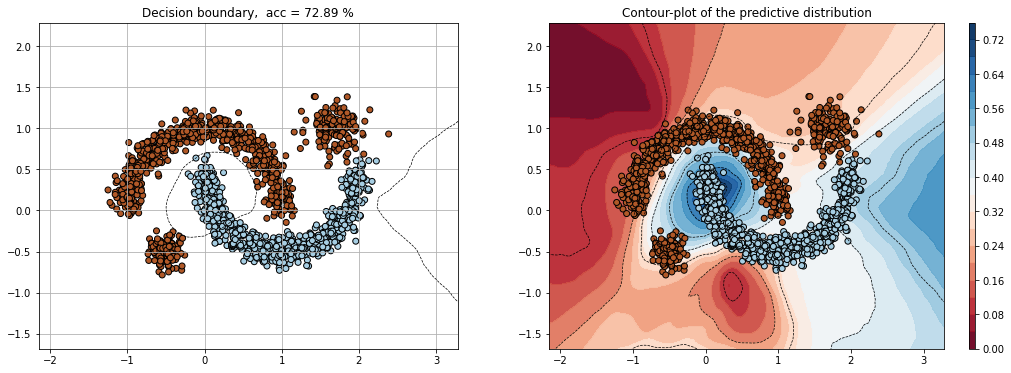

In [58]:
# approximation of the accuracy
beta = samples[-1]
acc = 100 * (np.sign(phi_X @ beta) == y).mean()

xlim, ylim = (X[:,0].min()-.9, X[:,0].max()+.9), (X[:,1].min()-.9, X[:,1].max()+.9)

# contour of the predictive distribution
xs = np.linspace(xlim[0], xlim[1], 100)
ys = np.linspace(ylim[0], ylim[1], 100)
xx, yy = np.meshgrid(xs, ys, sparse=False, indexing='ij')
zz = np.array([[xss,yss] for (xss,yss) in zip(xx.ravel(), yy.ravel())])
phi_zz = poly.transform(zz)
ZZ = predictive_MC(X_new=phi_zz, samples=samples, burn_in=100)
ZZ = ZZ.reshape(xx.shape).T

#fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = plt.subplots(1, 2, figsize=(2*9, 6), gridspec_kw={"width_ratios": [.85, 1]})

# visualize decision boundary 
ax[0].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
#x = np.linspace(-10, 10, 10)
#ax[0].plot(x, f(x), linestyle='--', color='k')
ax[0].set_ylim(ylim[0], ylim[1])
ax[0].set_xlim(xlim[0], xlim[1])
ax[0].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7, levels=[0.5])
ax[0].set_title("Decision boundary, "+" acc = {} %".format(round(acc, 2)))
ax[0].grid()

# contour of the predictive distribution
cont = ax[1].contourf(xs, ys, ZZ, 18, cmap='RdBu',
            vmin=ZZ.min(), vmax=ZZ.max(), alpha=.95)
fig.colorbar(cont, aspect=50)
ax[1].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7)
ax[1].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
ax[1].set_title("Contour-plot of the predictive distribution");

plt.show()

On observe bien **l'inefficacité** de cette méthode.

### 2.5 Application on a real dataset

On utilise le même datatset que celui utilisé precedemment, c'est à dire le dataset avec **17,898 échantillons**, chacun ayant **8 attributs** (features) et une classe binaire (stable, unstable).   
On conserve également les même training set et testings set pré-traités.

#### Application

In [59]:
# target distribution
target = lambda beta: np.exp(log_post_laplace(beta, X_train, y_train))

dim = X_train.shape[1]
n_samples = 5000
init_cov =  np.eye(dim)
init_mu = np.zeros(dim)
init_sample = np.ones(dim)
gamma = .8

samples, accept_ratio, alphas = adaptive_srwMH(n_samples, init_mu, init_cov, init_sample, gamma, dim=dim, target=target, reg=.1)
print("Acceptance ratio: {}".format(accept_ratio))

  1%|          | 27/5000 [00:00<00:04, 1135.20it/s]


LinAlgError: singular matrix

On rencontre donc le **même problème** que précedemment.

## 3 Hamiltonian methods: NUTS and HamiltonianMC from pymc

### 3.1 Description of the methods

Il semble à présent intéressant de comparer la SGLD aux méthodes Hamiltoniennes MCMC dont la Langevin MCMC fait partie. Nous avons appréhendé cette famille d'approche grâce à l'article didactique de Neal https://arxiv.org/abs/1206.1901. 

Sans rentrer dans les détails, nous introduisons les notations et principes majeurs des méthodes Hamiltoniennes.
De manière générale, elles se basent sur la dynamique du même nom pour générer des propositions et constuire une chaîne de Markov. L'idée est de prendre comme position $q$ la variable qui nous intéresse (ici $\beta$ dans la régression logistique). On définit de manière artificielle une quantité de mouvement $p$. Le Hamiltonien est alors une fonction de ces deux variables que l'on prend séparable comme suit:
$$ H(q,p) = U(q) + K(p)$$

Où $U$ peut être comprise par analogie comme une énergie potentielle et $K$ comme une énergie cinétique. On prend alors $K$ sous forme quadratique: 
$$K(p) = p^T M p$$

où $M$ est une matrice de masse.

Pour ce qui est de $U$, l'idée est de choisir l'opposé du log-posterior.

On définit alors une loi jointe sur les variables $(q,p)$ comme suit:

$$ p(q,p) = \frac {1}{Z} exp\bigg(-(U(q)+K(p))\bigg)$$


On peut alors itérer en alternant:
- une phase d'échantillonnage de $p$ selon la loi gaussienne définie naturellement par $p(p) \propto exp(-K(p))$, indépendamment de la position $q$. On voit que ce choix d'énergie cinétique quadratique induit naturellement une variable Gaussienne que l'on injecte dans le modèle, notamment décrit au dessus pour la SGLD.
- une phase d'échantillonnage de type Metropolis-Hastings, où la proposition est calculée par simulation de la dynamique Hamiltonienne sur un horizon fixé en partant des valeurs courantes de la position et de la quantité de mouvement en conditions initiales. Une discrétisation temporelle est opérée (pas de temps $\delta t$, horizon $T=L \times \delta t$), et un schéma d'intégration est mis en place. Cette dynamique est donnée par:

$$ \frac{dq}{dt} = \frac{\partial H}{\partial p}$$
$$ \frac{dp}{dt} = -\frac{\partial H}{\partial q}$$


La méthode de Langevin est un cas particulier où le nombre de pas de temps simulés est égal à $1$: $L=1$. La matrice de masse est de plus prise diagonale égale à l'identité dans l'article. Les échantillonneurs tels que NUTS de Pymc proposent une matrice de masse diagonale avec des poids adaptés automatiquement aux données.

Notons qu'une température $T$ est parfois introduite, dans ce cas:
$$ p(q,p) = \frac {1}{Z} exp\bigg(-\frac{(U(q)+K(p))}{T}\bigg)$$


### 3.2 Implementation using Pymc

In [71]:
import pymc3 as pm
import theano.tensor as tt

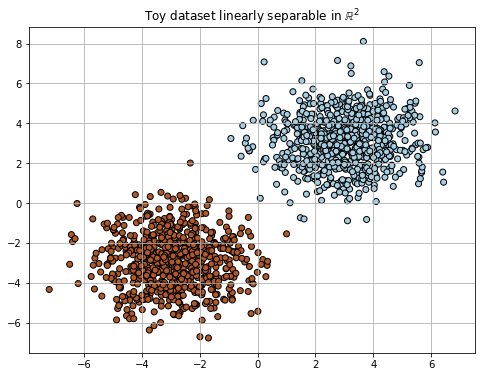

In [72]:
# load linearly separable dataset
X, y = make_blobs(n_samples=1500, centers=[(-3,-3),(3,3)], cluster_std=1.3, n_features=2, random_state=42)
y = 2 * y - 1

# visualize dataset
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Paired_r', edgecolors='k')
plt.title("Toy dataset linearly separable in $\mathbb{R}^2$")
plt.grid()
plt.show()

In [77]:
print(X.shape)

(1500, 2)


In [80]:
def get_mcmc_sample_for_laplace_prior(X, y):
    log_reg = pm.Model()
    with log_reg:
        prior_location = 0
        prior_scale = 1
        beta = pm.Laplace('beta', mu=prior_location, b=prior_scale, shape=X.shape[1])
        z = tt.dot(X, beta)
        theta = pm.Deterministic('theta', pm.math.sigmoid(z))
        y_1 = pm.Bernoulli('y_1', p=theta, observed=y)
        trace = pm.sample(2000, target_accept=.8)

    return trace

In [81]:
trace_ = get_mcmc_sample_for_laplace_prior(X,y)

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'beta': array([0., 0.])}

Initial evaluation results:
beta   -1.84
y_1     -inf
Name: Log-probability of test_point, dtype: float64